In [ ]:
## To access Global Flood Database Data, run:
# gsutil -m cp -r gs://gfd_v1_4 "your\local\repository"
## Install gsutil first: https://cloud.google.com/storage/docs/gsutil_install
## GFD repo is available at: https://github.com/cloudtostreet/MODIS_GlobalFloodDatabase

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from dask.diagnostics import ProgressBar
from geocube.api.core import make_geocube

PATH = "Z:\Laboral\World Bank\CLIENT v2"
DATA_RAW = rf"{PATH}\Data\Data_raw"
DATA_PROC = rf"{PATH}\Data\Data_proc"
DATA_OUT = rf"{PATH}\Data\Data_out"

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [91]:
adm_id_full = xr.open_dataset(rf"E:/client_v2_data/WB_country_grid.nc")
adm_id_full

<xarray.Dataset> Size: 6GB
Dimensions:  (y: 17173, x: 43200)
Coordinates:
  * y        (y) float64 137kB 83.62 83.61 83.6 83.6 ... -59.46 -59.47 -59.48
  * x        (x) float64 346kB -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    ID       (y, x) float64 6GB ...

In [61]:
def get_bounds_from_chunk_number(chunk_number, total_chunks=8):
    """Get the bounding box coordinates for a given chunk number.

    Data is divided into total_chunks chunks, each covering an 1/total_chunks of the globe.

    Parameters:
    -----------
    chunk_number: int
        Chunk number < total_chunks.
    total_chunks: int
        Total number of chunks to divide the globe into.

    Returns:
    --------
    tuple: Bounding box coordinates (left, bottom, right, top).
    """

    if chunk_number > total_chunks - 1:
        raise ValueError("Chunk number must be less than total_chunks.")

    # Define the bounding box coordinates for each chunk
    x_min = -180
    x_max = 180
    y_min = -90
    y_max = 90

    # Calculate the bounding box coordinates for the given chunk number
    side_chunks = np.sqrt(total_chunks)
    if not side_chunks.is_integer():
        raise ValueError("Total chunks must be a square number.")
    side_chunks = int(side_chunks)

    chunk_position = np.unravel_index(chunk_number, (side_chunks, side_chunks))

    x_step = (x_max - x_min) / side_chunks
    y_step = (y_max - y_min) / side_chunks

    left = x_min + chunk_position[0] * x_step
    right = left + x_step
    bottom = y_min + chunk_position[1] * y_step
    top = bottom + y_step

    return (left, bottom, right, top)


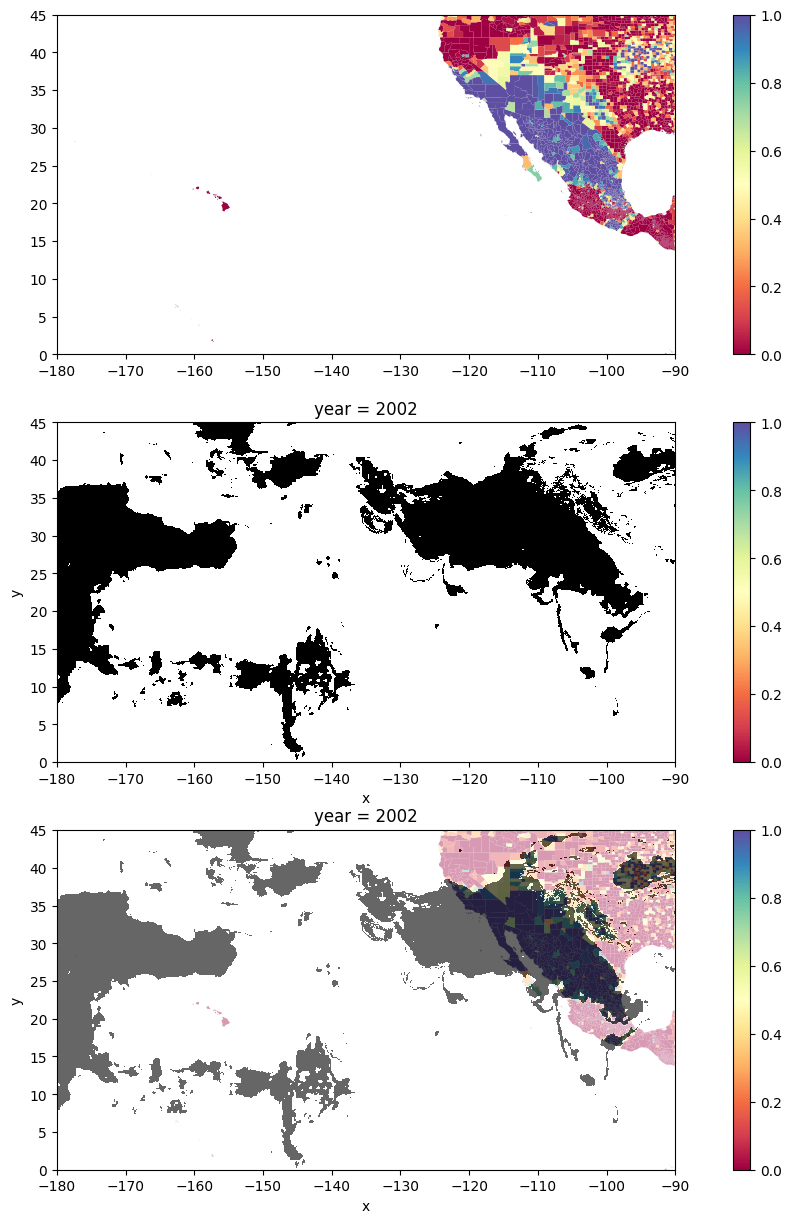

In [112]:
chunk = 2
year = 2002
var = "SPEI-12_1_0"

df = pd.read_parquet(rf"Z:\Laboral\World Bank\CLIENT v2\Data\Data_proc\shocks\drought_{var}_{year}_{chunk}_zonal_stats.parquet")
gdf = gpd.read_feather(r"E:\client_v2_data\WB_country_IDs.feather")
merged = gdf.merge(df, left_on="ID", right_index=True, validate="1:1")

ds = xr.open_dataset(r"E:\client_v2_data\ERA5_droughts_1970-2021.nc")
chunk_bounds = get_bounds_from_chunk_number(chunk, 16)
ds = ds.sel(x=slice(chunk_bounds[0], chunk_bounds[2]), y=slice(chunk_bounds[3], chunk_bounds[1]), year=year)

fig, axs = plt.subplots(3, 1, figsize=(15, 15))

# merged.plot(column="area_affected", ax=axs[1])
merged.plot(column="area_affected", ax=axs[0], legend=True, cmap="Spectral")
merged.plot(column="area_affected", ax=axs[1], legend=True, cmap="Spectral", alpha=0)
merged.plot(column="area_affected", ax=axs[2], legend=True, cmap="Spectral")
ds[f"drought_{var}"].plot(ax=axs[1], add_colorbar=False, cmap="Greys")
ds[f"drought_{var}"].plot(ax=axs[2], add_colorbar=False, cmap="Greys", alpha=0.6)

for ax in axs:
    ax.set_xlim(chunk_bounds[0], chunk_bounds[2])
    ax.set_ylim(35, 45)


In [3]:
droughts = xr.open_dataset(rf"E:/client_v2_data/ERA5_droughts_1970-2021.nc")
chunk_bounds = (-180, -90, 90, 0)

chunk_droughts = droughts.sel(
    x=slice(chunk_bounds[0], chunk_bounds[2]), y=slice(chunk_bounds[3], chunk_bounds[1])
).load()


In [5]:
chunk_droughts["drought_SPI-1_1_0"].sel(year=1997).values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [9]:
era5 = xr.open_dataset(rf"{DATA_PROC}\ERA5_monthly_1970-2021.nc", chunks={'latitude': 100, 'longitude': 100, 'time': 5})
era5 = era5.rename({'latitude': 'y', 'longitude': 'x'})
era5

<xarray.Dataset> Size: 159GB
Dimensions:  (time: 612, y: 1799, x: 3600)
Coordinates:
  * x        (x) float32 14kB 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * y        (y) float32 7kB 89.9 89.8 89.7 89.6 ... -89.6 -89.7 -89.8 -89.9
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2020-12-01
Data variables:
    d2m      (time, y, x) float64 32GB dask.array<chunksize=(5, 100, 100), meta=np.ndarray>
    t2m      (time, y, x) float64 32GB dask.array<chunksize=(5, 100, 100), meta=np.ndarray>
    sp       (time, y, x) float64 32GB dask.array<chunksize=(5, 100, 100), meta=np.ndarray>
    tp       (time, y, x) float64 32GB dask.array<chunksize=(5, 100, 100), meta=np.ndarray>
    PET      (y, x, time) float64 32GB dask.array<chunksize=(100, 100, 5), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-11 19:34:49 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [109]:
WB_country_grid = xr.open_dataset(rf"{DATA_PROC}\WB_country_grid.nc", chunks={'x': 100, 'y': 100})
WB_country_grid

# Filter these bounds 5.343009,40.639947,20.244439,50.052846
WB_country_grid = WB_country_grid.sel(x=slice(5.343009, 10.244439), y=slice(50.052846, 45.639947))
# era5 = era5.sel(x=slice(5.343009, 10.244439), y=slice(50.052846, 45.639947))

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'ee', 'gini', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [12]:
era5_resamp = era5.interp_like(WB_country_grid, method="nearest")
with ProgressBar():
    era5_resamp = era5_resamp.compute()

[########################################] | 100% Completed | 10m 44s


In [17]:
era5_resamp = era5_resamp.chunk({'x': 100, 'y': 100, 'time': 5})

In [42]:
era5_yearly = era5_resamp["PET"].groupby('time.year').mean()
with ProgressBar():
    era5_yearly = era5_yearly.compute()

[########################################] | 100% Completed | 23.86 s


In [101]:
import xrspatial
import dask


tasks = []
era5_yearly = era5_yearly.chunk({"x":100, "y":100, "year":1})
for year in range(1970, 2021):
    era5_year = era5_yearly.sel(year=year).drop_vars("year")
    tasks += [xrspatial.zonal.stats(zones=WB_country_grid.ADM2_CODE, values=era5_year)]
with ProgressBar():
    results = dask.compute(*tasks)#.compute()
# era5_resamp.PET

NameError: name 'warnings' is not defined

In [97]:
out_dict = {year: data.set_index("zone") for year, data in zip(range(1970,2021), results)}
df = pd.concat(out_dict)
df = df.reset_index()
df = df.rename(columns={"level_0":"year"})
df

,year,zone,mean,max,min,sum,std,var,count
0,1970,5664.0,24.702717,27.377863,23.975218,6150.976632,0.742825,0.551789,249.0
1,1970,5666.0,29.793084,29.793084,29.793084,119.172334,0.000000,0.000000,4.0
2,1970,5668.0,29.359910,37.126944,23.975218,63652.285598,2.799909,7.839490,2168.0
3,1970,5669.0,35.525832,44.201281,27.494735,53537.428714,4.595141,21.115319,1507.0
4,1970,5670.0,38.471440,42.699828,34.954729,10887.417413,2.163285,4.679801,283.0
...,...,...,...,...,...,...,...,...,...
3004,2020,19179.0,61.384123,61.853518,60.764186,13872.811740,0.343519,0.118005,226.0
3005,2020,19180.0,60.789678,61.052611,60.611062,22735.339706,0.153855,0.023671,374.0
3006,2020,19181.0,60.866147,61.853518,60.236568,27268.033732,0.467428,0.218489,448.0
3007,2020,19182.0,60.759021,61.853518,60.540430,26977.005170,0.261029,0.068136,444.0


In [108]:
WB_country_grid.ADM2_CODE.values.max()

0.0

In [102]:
df.head(30)

,year,zone,mean,max,min,sum,std,var,count
0,1970,5664.0,24.702717,27.377863,23.975218,6150.976632,0.742825,0.551789,249.0
1,1970,5666.0,29.793084,29.793084,29.793084,119.172334,0.000000,0.000000,4.0
2,1970,5668.0,29.359910,37.126944,23.975218,63652.285598,2.799909,7.839490,2168.0
3,1970,5669.0,35.525832,44.201281,27.494735,53537.428714,4.595141,21.115319,1507.0
4,1970,5670.0,38.471440,42.699828,34.954729,10887.417413,2.163285,4.679801,283.0
5,1970,5671.0,37.592285,41.686776,32.561600,18345.035033,1.901218,3.614630,488.0
6,1970,5852.0,45.258800,46.964865,43.977399,125095.322614,0.946662,0.896168,2764.0
7,1970,16238.0,47.967642,49.820452,44.361438,404607.058469,1.311208,1.719266,8435.0
8,1970,16239.0,46.296587,49.492144,42.079152,282177.699816,1.836026,3.370991,6095.0
9,1970,16252.0,49.825964,50.259996,48.990255,21176.034678,0.433814,0.188195,425.0


In [ ]:
def crop_xarray_by_poygon(dataset, polygon):
    minx, miny, maxx, maxy = polygon.bounds

    dataset = dataset.sel(y=slice(maxy, miny), x=slice(minx, maxx))

    return dataset


def create_carray_mask_from_polygon(dataset, polygon):
    import rasterio

    arr = rasterio.features.geometry_mask(
        [polygon],
        out_shape=(len(dataset.y), len(dataset.x)),
        transform=dataset.rio.transform(),
        invert=True,
    )
    mask = xr.DataArray(
        arr,
        coords={
            "x": dataset.x,
            "y": dataset.y,
        },
        dims=["y", "x"],
    )

    return mask

In [ ]:
# floods = pd.read_csv(rf"{DATA_RAW}\Floods\GloFAS_floods.csv")
population = xr.open_dataset(
    r"Z:\Laboral\World Bank\Vulnerability Index\data\data_in\Grided Population\gpw_v4_population_count_rev11_2020_30_sec.tif"
)  # FIXME: Tendría que usar la del año correspondiente, no la de 2020
population = population.sel(band=1).drop_vars(["band"])

era5 = xr.open_dataset(
    rf"{DATA_OUT}\ERA5_monthly_1970-2021_SPI-SPEI.nc",
    chunks={"latitude": 1000, "longitude": 1000},
)
era5 = era5.rename({"latitude": "y", "longitude": "x"})

In [ ]:
wb_shp = gpd.read_file(rf"{DATA_RAW}\world_bank_adm2.zip")
wb_shp.loc[wb_shp.ADM2_NAME == "Administrative unit not available", "ADM2_CODE"] = (
    np.nan
)
# Create ADM_LAST variable: ADM2_NAME if available, else ADM1_NAME
wb_shp["ADM_LAST"] = wb_shp.ADM2_NAME
wb_shp.loc[wb_shp.ADM_LAST.isnull(), "ADM_LAST"] = wb_shp.ADM1_NAME

In [ ]:
country = wb_shp[wb_shp.ADM0_CODE == 122]

In [ ]:
# Polygon with the country shape
country_polygon = country.unary_union

# Keep only India from population and floods
min_x, min_y, max_x, max_y = country.total_bounds
population = population.sel(y=slice(max_y, min_y), x=slice(min_x, max_x))
era5 = crop_xarray_by_poygon(era5, country_polygon)

# # Interpolate like floods
# era5_resamp = era5.interp_like(population, method="nearest")
# with ProgressBar():
#     era5_resamp = era5_resamp.compute()

In [ ]:
ds = xr.combine_by_coords([population, era5_resamp], combine_attrs="override")
ds = ds.sel(band=1).drop_vars(["band", "spatial_ref"])
ds["x"] = ds["x"].astype("float32")
ds["y"] = ds["y"].astype("float32")
ds = ds.chunk({"y": 1000, "x": 1000})

In [ ]:
ds = ds.chunk({"y": 1000, "x": 1000})

In [ ]:
country_grid[["x", "y"]]

In [ ]:
# Rasterize the country shapes
country_grid = make_geocube(
    vector_data=country[["ADM1_CODE", "ADM2_CODE", "ADM_LAST", "geometry"]],
    like=population,
)
# For some reason, like option is not working, so I have to manually add x and y
assert (country_grid["x"].shape == population["x"].shape)
assert (country_grid["y"].shape == population["y"].shape)
country_grid["x"] = population["x"]
country_grid["y"] = population["y"]

# Combine the population and country grid
ds_geocube = xr.combine_by_coords(
    [
        population,
        country_grid,
    ],
    combine_attrs="override",
)
ds_geocube

In [ ]:
population.band_data.plot()

In [ ]:
pop_by_adm = (
    ds_geocube["band_data"].groupby(ds_geocube["ADM2_CODE"]).sum().to_dataframe()
)
joined = (
    country[["ADM1_CODE", "ADM2_CODE", "ADM_LAST", "geometry"]]
    .set_index("ADM2_CODE")
    .join(pop_by_adm)
)
joined.explore(column="band_data")

In [ ]:
import regionmask

# Create mask of multiple regions from shapefile
eu_mask = regionmask.mask_3D_geopandas(
    country[["ADM2_CODE", "geometry"]].dropna(subset="ADM2_CODE"),
    ds.x,
    ds.y,
    drop=False,
    # numbers="ADM2_CODE"
)
# Apply mask on our dataset
test = ds["SPI-1"].where(eu_mask)
test = test.chunk({"x": 20, "y": 20, "time": 1, "region": 1})

with ProgressBar():
    agg_by_time = (
        test.groupby("region")
        .mean(dim=["x", "y"], method="map-reduce", engine="flox")
        .compute()
    )

In [ ]:
with ProgressBar():
    agg_by_time = test.groupby("region").mean(dim=["x", "y"]).compute()

In [ ]:
test.isel(region=25).plot()

In [ ]:
ds.sel(ADM1_CODE=40544)["SPI-1"].isel(time=30).plot()

In [ ]:
ds.sel(ADM1_CODE=40542)["SPI-1"].isel(time=30).plot()

In [ ]:
ds.groupby("ADM2_CODE")["SPEI-12"]

In [ ]:
ds[["SPI-1", "ADM2_CODE"]]

In [ ]:
ds = ds.sel(band=1).drop(["spatial_ref", "band"])

In [ ]:
# For simplicity, let's say ADM1 is a 2D array with same x, y dimensions
adm1_dim = ds.ADM1_CODE

# Create a new dimension 'adm1' for ADM1 levels
dataset = ds.expand_dims(dim="ADM1_level", axis=2)

# Assign precipitation data to this new dataset structure
dataset["SPI-1"] = dataset["SPI-1"].assign_coords(ADM1_level=adm1_dim)

# Now your dataset has 'x', 'y', and 'ADM1' as dimensions
# (x, y, ADM1_level) structure with precipitation values tagged with corresponding ADM1 codes

# Optionally, if the ADM1 codes are unique and you want to have them as a coordinate dimension:
adm1_unique = adm1_dim.values.flatten()
adm1_unique = np.unique(adm1_unique)

dataset = dataset.assign_coords(ADM1_level=("ADM1_level", adm1_unique))
dataset

In [ ]:
ds_flat = ds.stack(z=("y", "x"))
ds_flat.groupby("ADM1_CODE")["SPI-1"]

In [ ]:
ds.isel(time=30).groupby("ADM1_CODE")  # ["SPI-1"]#.mean(dim=["x", "y"])

In [ ]:
(ds["SPI-1"] * ds.band_data).groupby("ADM2_CODE").sum(dim=("x", "y"))

In [ ]:
# This is OLD
import pandas as pd
from tqdm import tqdm


def compute_share_affected_population(floods, population):

    import numpy as np

    # Calculate affected population for the selected municipality
    population_affected = (floods_resamp * population).sum(dim=("x", "y"))
    area_affected = (floods).sum(dim=("x", "y"))

    # Calculate total population for the selected municipality
    total_population = population.sum(dim=("x", "y"))
    total_area = floods.count(dim=("x", "y"))

    # Calculate share of population affected by floods
    share_population_affected = (
        population_affected / total_population
    ).band_data.values[0]
    share_area_affected = (area_affected / total_area).band_data.values[0]

    # Return value
    return share_population_affected, share_area_affected


def plot_population_vs_floods(floods, population, polygon):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    floods.rio.clip([polygon]).band_data.plot(ax=ax[0])
    population.rio.clip([polygon]).band_data.plot(ax=ax[1])

    return fig, ax


# Create emty dataframe to store results

if KIND == "DHS":
    admin_name_col = "ADM2_NAME"  # Esto solo si trabajamos con DHS desagregada! FIXME
    admin_code_col = "ADM2_CODE"
    country_map = country_map.dissolve(by="ADM2_CODE").reset_index()
elif KIND == "IPUMS":
    admin_name_col = "ADMIN_NAME"
    admin_code_col = "GEOLEVEL2"

results = pd.DataFrame()
for i in tqdm(range(0, len(country_map))):

    polygon = country_map.geometry[i]

    # Crop xarray to reduce size
    floods_min = crop_xarray_by_poygon(floods, polygon)
    floods_resamp_min = crop_xarray_by_poygon(floods_resamp, polygon)
    population_min = crop_xarray_by_poygon(population, polygon)

    # Clip xarray by poluygon
    floods_min = floods_min.where(create_carray_mask_from_polygon(floods_min, polygon))
    floods_resamp_min = floods_resamp_min.where(
        create_carray_mask_from_polygon(floods_resamp_min, polygon)
    )
    population_min = population_min.where(
        create_carray_mask_from_polygon(population_min, polygon)
    )

    # plot_population_vs_floods(floods, population, polygon)
    share_pop_affected, share_area_affected = compute_share_affected_population(
        floods_min, floods_resamp_min, population_min
    )

    # add to dataframe
    results.loc[i, admin_name_col] = country_map[admin_name_col][i]
    results.loc[i, admin_code_col] = country_map[admin_code_col][i]
    results.loc[i, "POP_PERCENT_AFFECTED"] = share_pop_affected * 100
    results.loc[i, "AREA_PERCENT_AFFECTED"] = share_area_affected * 100

results

In [ ]:
ds = (
    xr.combine_by_coords([population, era5_resamp])
    .rename({"band_data": "POPULATION"})
    .sel(band=1)
)

In [ ]:
# ds["drought_spi1_2"] =
ds["drought"] = ds["SPI-1"] < -0.5

In [ ]:
def calculate_per_municipality(ds, geom):
    population_affected = (ds.drought * ds.POPULATION.where(geom)).sum(dim=("x", "y"))
    # area_affected = (ds..where(geom)).sum(dim=('x', 'y'))
    # total_population = population_min.where(geom).sum(dim=('x', 'y'))
    # total_area = ds.where(geom).count(dim=('x', 'y'))

    # share_population_affected = (population_affected / total_population).data[0]
    # share_area_affected = (area_affected / total_area).data[0]
    return population_affected  # share_population_affected, share_area_affected


calculate_per_municipality(ds, country.geometry[0])

In [ ]:
import xarray as xr


# Assuming your geodataframe's geometry column is called 'geometry'
def vectorized_calculation(ds, polygon):
    # 1. Use xr.apply_ufunc with a custom function for municipality-wise calculation
    def calculate_per_municipality(ds, geom):
        population_affected = (ds.drought * population_min.where(geom)).sum(
            dim=("x", "y")
        )
        # area_affected = (ds..where(geom)).sum(dim=('x', 'y'))
        # total_population = population_min.where(geom).sum(dim=('x', 'y'))
        # total_area = ds.where(geom).count(dim=('x', 'y'))

        # share_population_affected = (population_affected / total_population).data[0]
        # share_area_affected = (area_affected / total_area).data[0]
        return population_affected  # share_population_affected, share_area_affected

    # Crop xarray to reduce size
    ds = crop_xarray_by_poygon(ds, polygon)
    ds = ds.where(create_carray_mask_from_polygon(ds, polygon))

    # 2. Apply the function along the geometry dimension with vectorized operations
    results = xr.apply_ufunc(ds, polygon, vectorize=True)

    return results


# Call the function with the geodataframe geometry
share_pop_affected, share_area_affected = vectorized_calculation(ds, country.geometry)

In [ ]:
import pandas as pd

pd.options.plotting.backend = "plotly"

results.PERCENT_AFFECTED.plot()

In [ ]:
# population.to_netcdf("pop_india.nc")ds.rio.write_crs("epsg:4326", inplace=True)
floods_resamp = floods_resamp.sortby(["y", "x", "band"])
floods_resamp.rio.write_crs("epsg:4326")
floods_resamp.band_data.rio.to_raster("floods_india.tif")

In [ ]:
def plot_treatment(india_map, results):

    india_map.merge(results, on="ADM2_CODE", how="inner").plot(
        column="TREATED", legend=True
    )

    return


plot_treatment(country_map, results)